# Prediksi Kecepatan Angin Maksimum di Tanjungpinang Tahun 2022 dengan ARIMA

Notebook ini dibuat untuk proyek akhir Pembelajaran Mesin. Topik dari proyek ini adalah memprediksi kecepatan angin maksimum di Tanjungpinang tahun 2022 dengan model ARIMA.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.linalg import toeplitz, lstsq
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_predict, plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error

## Fungsi Utilitas

## Pengertian ARIMA

## Pengujian Model dengan Data Dummy

In [15]:
# Membuat data dummy
data_dummy = pd.read_csv('./kecepatan_angin_dummy.csv')
data_dummy

,kecepatan_angin
0,7
1,8
2,14
3,5
4,14
5,3
6,12
7,8
8,5
9,9


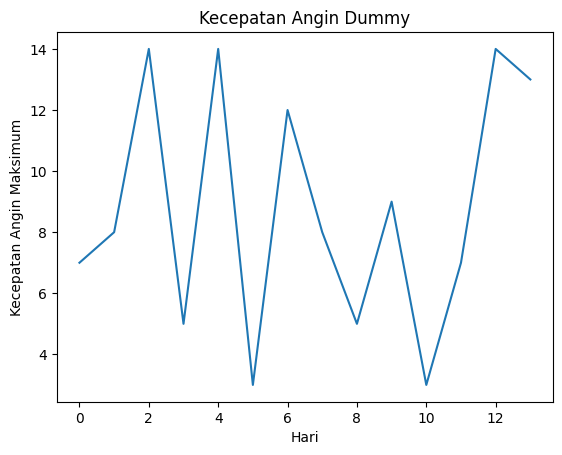

In [16]:
dummy_kec_angin = data_dummy['kecepatan_angin']

# Plot dataset dummy
fig, ax = plt.subplots()
plt.plot(dummy_kec_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Dummy')

plt.show()

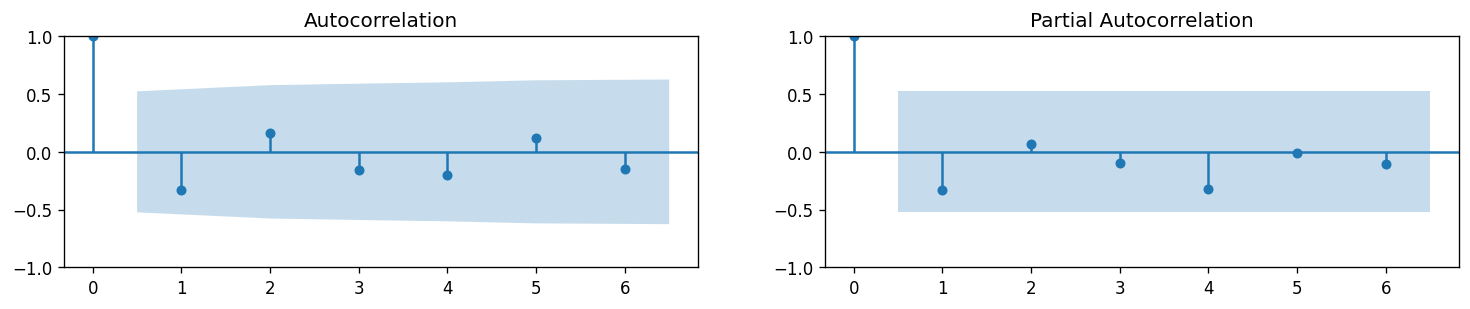

In [28]:
plt.rcParams.update({'figure.figsize':(15,2.5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)

plot_acf(dummy_kec_angin, ax=axes[0], lags=6)
plot_pacf(dummy_kec_angin, ax=axes[1], lags=6)

plt.show()

In [31]:
model = ARIMA(dummy_kec_angin, order=(2, 0, 1))
model_fit = model.fit()

c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


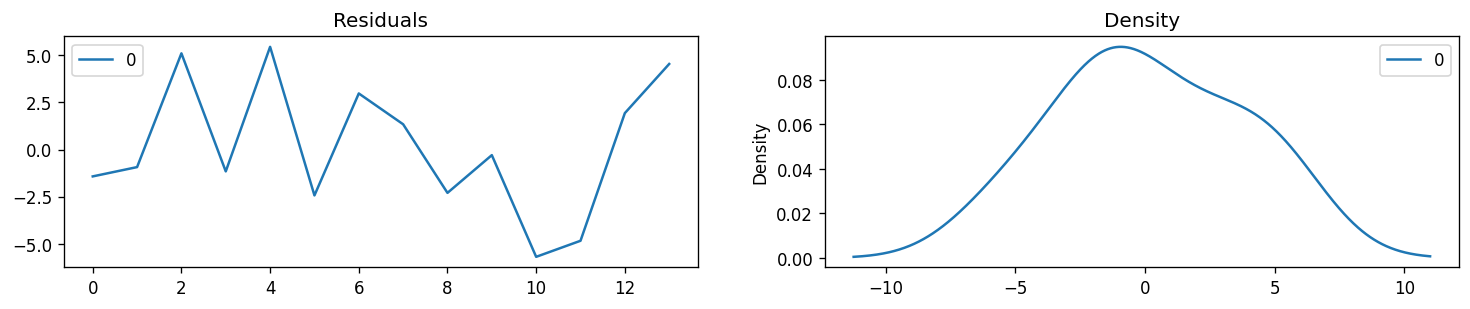

In [32]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

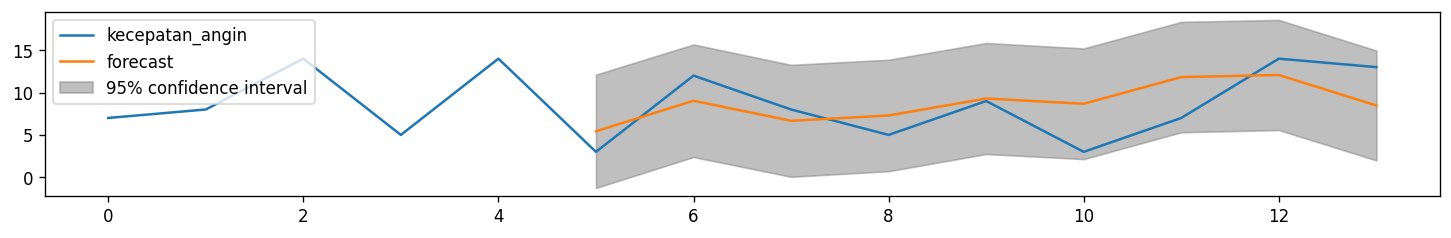

In [42]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,2))
ax = dummy_kec_angin.plot(ax=ax)
fig = plot_predict(model_fit, start=5, dynamic=False, ax=ax, plot_insample=False)
plt.show()

In [41]:
mean_absolute_error(model_fit.predict()[5:], dummy_kec_angin[5:])

2.91939860582676

In [45]:
print('=== MAE ===')

for p in range(3):
    for d in range(2):
        for q in range(3):
            olah_kecepatan_angin = dummy_kec_angin
            if d > 0:
                for _ in range(d):
                    olah_kecepatan_angin = olah_kecepatan_angin.diff().fillna(0)

            model = ARIMA(olah_kecepatan_angin, order=(p, d, q))
            model_fitted = model.fit()
            mae = mean_absolute_error(model_fit.predict()[5:], olah_kecepatan_angin[5:])
            print(f'ARIMA({p}, {d}, {q}): {mae}')

=== MAE ===
ARIMA(0, 0, 0): 2.91939860582676
ARIMA(0, 0, 1): 2.91939860582676
ARIMA(0, 0, 2): 2.91939860582676
ARIMA(0, 1, 0): 8.862406559263706


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 1): 8.862406559263706


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 2): 8.862406559263706
ARIMA(1, 0, 0): 2.91939860582676
ARIMA(1, 0, 1): 2.91939860582676
ARIMA(1, 0, 2): 2.91939860582676
ARIMA(1, 1, 0): 8.862406559263706
ARIMA(1, 1, 1): 8.862406559263706
ARIMA(1, 1, 2): 8.862406559263706
ARIMA(2, 0, 0): 2.91939860582676


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 1): 2.91939860582676
ARIMA(2, 0, 2): 2.91939860582676
ARIMA(2, 1, 0): 8.862406559263706
ARIMA(2, 1, 1): 8.862406559263706
ARIMA(2, 1, 2): 8.862406559263706


## Membuka Dataset

In [21]:
# Buka dataset
df_kecepatan_angin = pd.read_csv('./kecepatan_angin_tpi_2022.csv',
                                 delimiter=';'
                                )
df_kecepatan_angin

,tanggal,kecepatan_maksimum
0,01/01/2022,4
1,02/01/2022,3
2,03/01/2022,3
3,04/01/2022,6
4,05/01/2022,7
...,...,...
361,28/12/2022,6
362,29/12/2022,8
363,30/12/2022,10
364,31/12/2022,13


In [22]:
df_kecepatan_angin['kecepatan_maksimum'].describe()

count    366.000000
mean       5.838798
std        1.854642
min        3.000000
25%        5.000000
50%        6.000000
75%        7.000000
max       15.000000
Name: kecepatan_maksimum, dtype: float64

In [23]:
# Konversi tipe data kolom tanggal menjadi tipe data datetime
df_kecepatan_angin['tanggal'] = pd.to_datetime(df_kecepatan_angin['tanggal'], dayfirst=True)

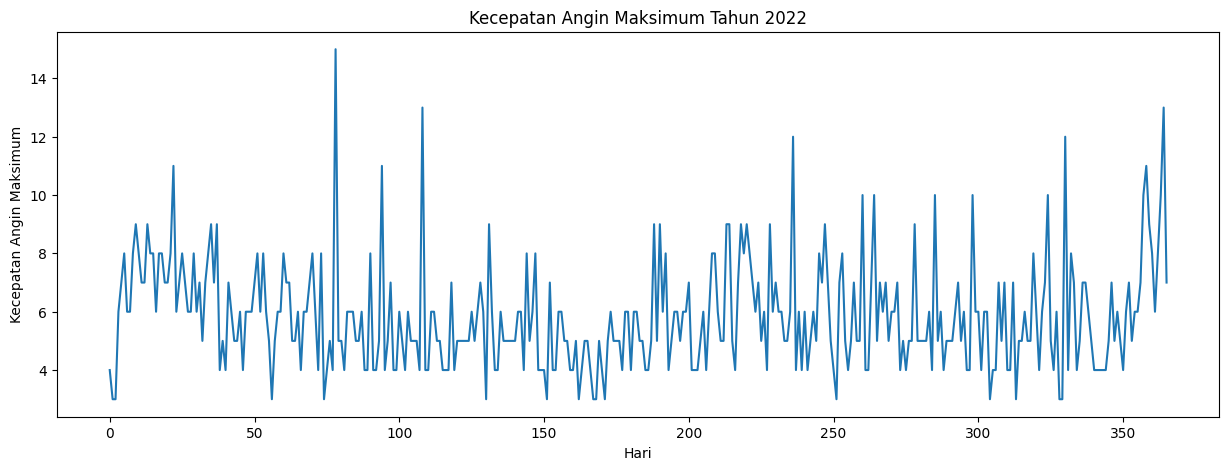

In [24]:
kecepatan_angin = df_kecepatan_angin['kecepatan_maksimum']

# Plot dataset
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin)

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')

plt.show()

In [25]:
# Scatter dataset
scatter_kec_angin_per_hari = create_windowed_dataset(kecepatan_angin, 2)

fig, ax = plt.subplots()
plt.scatter(scatter_kec_angin_per_hari[:,0], scatter_kec_angin_per_hari[:,1])

ax.set_xlabel('Hari')
ax.set_ylabel('Kecepatan Angin Maksimum')
ax.set_title('Kecepatan Angin Maksimum Tahun 2022')

plt.show()

NameError: name 'create_windowed_dataset' is not defined

## Menentukan Paramater untuk ARIMA

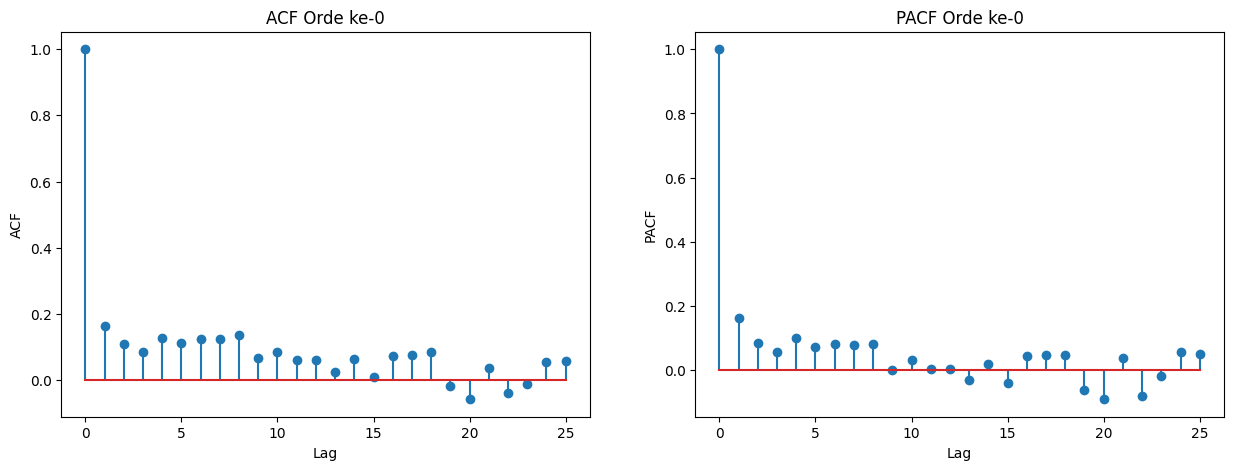

In [ ]:
# Plot 25 nilai ACF pertama dari dataset
acf_kec_angin = acf(kecepatan_angin)[:26]

# Plot 25 nilai PACF pertama dari dataset
pacf_kec_angin = pacf(kecepatan_angin)[:26]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].stem(acf_kec_angin)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF Orde ke-0')

ax[1].stem(pacf_kec_angin)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF Orde ke-0')

plt.show()

Berdasarkan grafik tersebut, karena tidak ada menunjukkan pola apayah, maka data kecepatan angin maksimum perlu di-_differencing_ (menghitung selisih antardata).

In [ ]:
print(kecepatan_angin)
print(kecepatan_angin.shift().fillna(method='bfill'))

0       4
1       3
2       3
3       6
4       7
       ..
361     6
362     8
363    10
364    13
365     7
Name: kecepatan_maksimum, Length: 366, dtype: int64
0       4.0
1       4.0
2       3.0
3       3.0
4       6.0
       ... 
361     8.0
362     6.0
363     8.0
364    10.0
365    13.0
Name: kecepatan_maksimum, Length: 366, dtype: float64


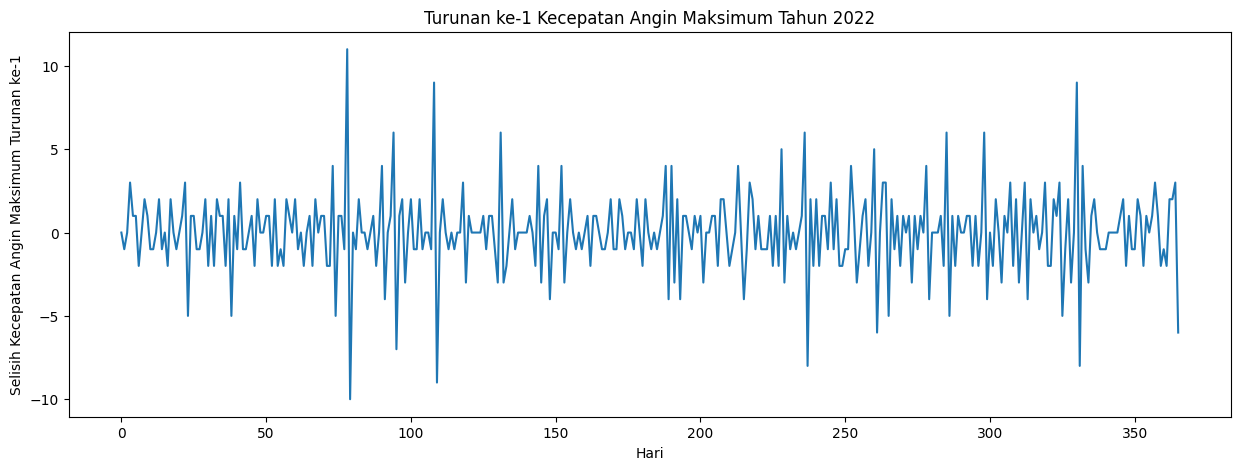

In [ ]:
kecepatan_angin_orde_1 = kecepatan_angin - kecepatan_angin.shift().fillna(method='bfill')

# Plot dataset turunan ke-1
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(kecepatan_angin_orde_1)

ax.set_xlabel('Hari')
ax.set_ylabel('Selisih Kecepatan Angin Maksimum Turunan ke-1')
ax.set_title('Turunan ke-1 Kecepatan Angin Maksimum Tahun 2022')

plt.show()

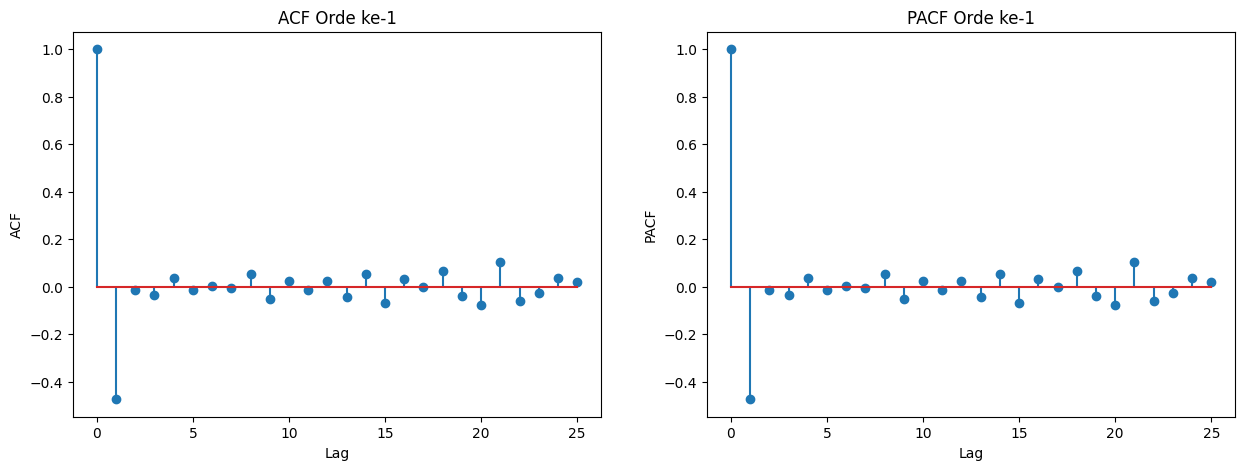

In [ ]:
# Plot 25 nilai ACF pertama dari dataset
acf_kec_angin = acf(kecepatan_angin_orde_1)[:26]

# Plot 25 nilai PACF pertama dari dataset
pacf_kec_angin = acf(kecepatan_angin_orde_1)[:26]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].stem(acf_kec_angin)
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')
ax[0].set_title('ACF Orde ke-1')

ax[1].stem(pacf_kec_angin)
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')
ax[1].set_title('PACF Orde ke-1')

plt.show()

In [ ]:
model = ARIMA(kecepatan_angin, order=(2, 2, 1))
model_fit = model.fit()

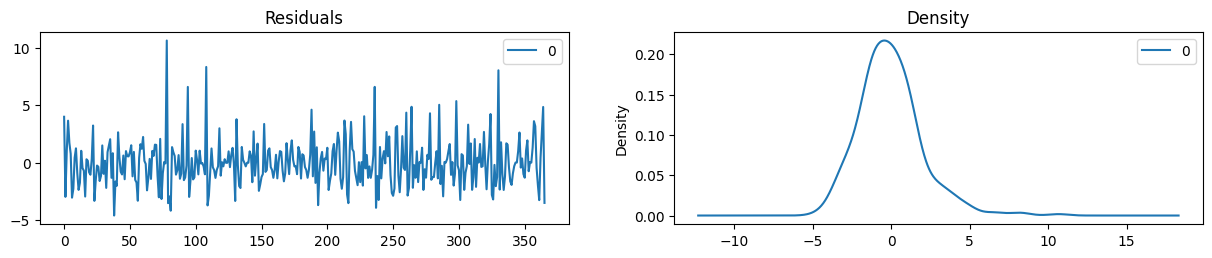

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2, figsize=(15,2.5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

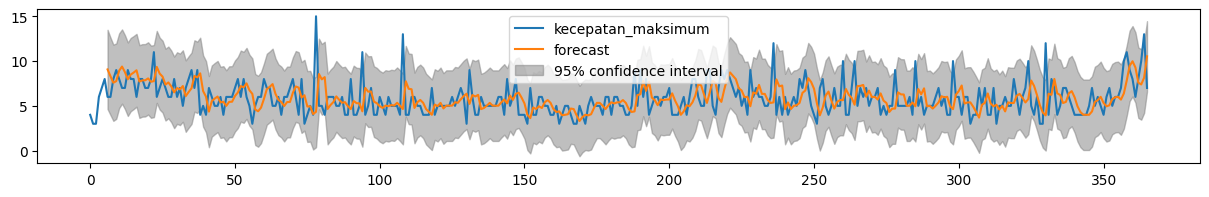

In [ ]:
# Actual vs Fitted
fig, ax = plt.subplots(figsize=(15,2))
ax = kecepatan_angin.plot(ax=ax)
fig = plot_predict(model_fit, start=6, dynamic=False, ax=ax, plot_insample=False)
plt.show()

In [52]:
kecepatan_angin[5:]

5       8
6       6
7       6
8       8
9       9
       ..
361     6
362     8
363    10
364    13
365     7
Name: kecepatan_maksimum, Length: 361, dtype: int64

In [67]:
model = ARIMA(kecepatan_angin, order=(0, 0, 0))
model_fitted = model.fit()
ce = model_fit.predict(start=15, end=365)
print(ce)

15     7.912452
16     8.096041
17     8.274940
18     8.349131
19     8.386489
         ...   
361    8.420883
362    8.420883
363    8.420883
364    8.420883
365    8.420883
Name: predicted_mean, Length: 351, dtype: float64


In [69]:
print('=== MAE ===')

for p in range(4):
    for d in range(2):
        for q in range(4):
            olah_kecepatan_angin = kecepatan_angin
            if d > 0:
                for _ in range(d):
                    olah_kecepatan_angin = olah_kecepatan_angin.diff().fillna(0)

            model = ARIMA(olah_kecepatan_angin, order=(p, d, q))
            model_fitted = model.fit()
            mae = mean_absolute_error(model_fit.predict(start=5, end=365), olah_kecepatan_angin[5:])
            print(f'ARIMA({p}, {d}, {q}): {mae}')

=== MAE ===
ARIMA(0, 0, 0): 2.868364222771901
ARIMA(0, 0, 1): 2.868364222771901
ARIMA(0, 0, 2): 2.868364222771901
ARIMA(0, 0, 3): 2.868364222771901
ARIMA(0, 1, 0): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 1): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 2): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(0, 1, 3): 8.440362333616426
ARIMA(1, 0, 0): 2.868364222771901
ARIMA(1, 0, 1): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 2): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 0, 3): 2.868364222771901
ARIMA(1, 1, 0): 8.440362333616426
ARIMA(1, 1, 1): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 2): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(1, 1, 3): 8.440362333616426
ARIMA(2, 0, 0): 2.868364222771901
ARIMA(2, 0, 1): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


ARIMA(2, 0, 2): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 0, 3): 2.868364222771901
ARIMA(2, 1, 0): 8.440362333616426
ARIMA(2, 1, 1): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 2): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(2, 1, 3): 8.440362333616426
ARIMA(3, 0, 0): 2.868364222771901
ARIMA(3, 0, 1): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 0, 2): 2.868364222771901


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(3, 0, 3): 2.868364222771901
ARIMA(3, 1, 0): 8.440362333616426
ARIMA(3, 1, 1): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA(3, 1, 2): 8.440362333616426
ARIMA(3, 1, 3): 8.440362333616426


c:\Users\Karkar\LABS\ml\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Membagi Data

## Melatih Data

## Menvalidasi Data